In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import wilcoxon, shapiro, levene, mannwhitneyu
from scipy.stats import skew, kurtosis, linregress
import kagglehub


In [ ]:
#Učitavanje podataka
path = kagglehub.dataset_download("sohier/calcofi")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'calcofi' dataset.
Path to dataset files: /kaggle/input/calcofi


In [ ]:
data = pd.read_csv(f"/kaggle/input/calcofi/bottle.csv")

/tmp/ipython-input-2427149501.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"/kaggle/input/calcofi/bottle.csv")


In [ ]:
print(data.head())

   Cst_Cnt  Btl_Cnt       Sta_ID                                Depth_ID  \
0        1        1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0000A-3   
1        1        2  054.0 056.0  19-4903CR-HY-060-0930-05400560-0008A-3   
2        1        3  054.0 056.0  19-4903CR-HY-060-0930-05400560-0010A-7   
3        1        4  054.0 056.0  19-4903CR-HY-060-0930-05400560-0019A-3   
4        1        5  054.0 056.0  19-4903CR-HY-060-0930-05400560-0020A-7   

   Depthm  T_degC  Salnty  O2ml_L  STheta  O2Sat  ...  R_PHAEO  R_PRES  \
0       0   10.50  33.440     NaN  25.649    NaN  ...      NaN       0   
1       8   10.46  33.440     NaN  25.656    NaN  ...      NaN       8   
2      10   10.46  33.437     NaN  25.654    NaN  ...      NaN      10   
3      19   10.45  33.420     NaN  25.643    NaN  ...      NaN      19   
4      20   10.45  33.421     NaN  25.643    NaN  ...      NaN      20   

   R_SAMP  DIC1  DIC2  TA1  TA2  pH2  pH1  DIC Quality Comment  
0     NaN   NaN   NaN  NaN  NaN  

1. Statističko zaključivanje o temperaturi u dvjema dubinskim zonama (Nezavisni uzorci)

In [ ]:
#uzimanje samo varijabli Depthm,T_degC,Salnty
data=data[['Depthm','T_degC','Salnty']]
data.dropna(inplace=True)
print(data.head())

   Depthm  T_degC  Salnty
0       0   10.50  33.440
1       8   10.46  33.440
2      10   10.46  33.437
3      19   10.45  33.420
4      20   10.45  33.421


In [ ]:
#1 Podjela i uzorkovanje podataka (korištenje uzoraka od 5000 slucajnih vrijednosti)
shallow = data[data["Depthm"] < 50]["T_degC"]
deep = data[data["Depthm"] > 200]["T_degC"]
# uzorkovanje po 5000 vrijednosti
shallow_sample = shallow.sample(5000, random_state=1)
deep_sample = deep.sample(5000, random_state=1)
print(shallow_sample)
print(deep_sample)

710026    16.65
654486    14.70
596554    14.27
680491    15.06
329975    13.92
          ...  
48223     17.42
597123    12.47
402511    14.54
643209    15.32
290386    18.85
Name: T_degC, Length: 5000, dtype: float64
840651     7.569
378337     6.330
788228     8.850
770124     7.940
314189    10.640
           ...  
224329     2.170
428771     6.110
490748     7.270
275525     3.930
467087     3.750
Name: T_degC, Length: 5000, dtype: float64


In [ ]:
#2 Ispitivanje normalnosti distribucije (Shapiro-Wilk test) i jednakosti varijanci (Leveneov test)
# Shapiro-Wilk test normalnosti
shallow_shapiro = shapiro(shallow_sample)
deep_shapiro = shapiro(deep_sample)

print("Shapiro pliće:", shallow_shapiro.pvalue)  #<0.05
print("Shapiro dublje:", deep_shapiro.pvalue)    #<0.05
# Ako je p < 0.05 → distribucija NIJE normalna => Mann-Whitney U test
# Ako je p > 0.05 → distribucija je normalna => t-test

#provjera jednakosti varijanci (Leveneov test)
lev = levene(shallow_sample, deep_sample)
print("Levene p-vrijednost:", lev.pvalue) #<0.05
# Ako je p > 0.05 → varijance su jednake (homoskedastičnost)
# Ako je p < 0.05 → varijance se razlikuju (heteroskedastičnost)

Shapiro pliće: 1.6349931056312463e-30
Shapiro dublje: 1.2324897143087226e-14
Levene p-vrijednost: 1.6988395680732354e-163


In [ ]:
#3 Odabir testa (t-test za nezavisne uzorke ili Mann–Whitney U test) ovisno o zadovoljenju pretpostavki.
# Mann-Whitney U test (neparametrijski)
u_stat, p_val = mannwhitneyu(shallow_sample, deep_sample)

print("Mann-Whitney U statistika:", u_stat)
print("p-vrijednost:", p_val)

Mann-Whitney U statistika: 24968993.5
p-vrijednost: 0.0


In [ ]:
#4 Testiranje hipoteze H0: mi_pliće=mi_dublje i interpretacija rezultata

# H0: Nema razlike u temperaturi između plićeg i dubljeg sloja
# H1: Postoji razlika u temperaturi između slojeva

# Ako je p < 0.05 → odbacujemo H0 → postoji značajna razlika
# Ako je p > 0.05 → NE odbacujemo H0 → nema značajne razlike

# U kontekstu oceana očekujemo da je temperatura niža na većim dubinama.
# Ako je p < 0.05, rezultat potvrđuje da se temperature statistički razlikuju.

2. Jednostavna linearna regresija (Temperatura => Dubina)

In [ ]:
#1 Priprema podataka: Uklanjanje ekstremnih ili nerealnih vrijednosti primjenom fizički smislenih raspona i IQR metode

# 1) Filtriranje fizički smislenih vrijednosti
data_filtered = data[
    (data["Depthm"].between(0, 1000)) &
    (data["T_degC"].between(-2, 30))
].copy()

print("Broj redaka nakon rucnog filtriranja:", len(data_filtered))

# 2) Uklanjanje outliera IQR metodom (na temperaturi)
Q1 = data_filtered["T_degC"].quantile(0.25)
Q3 = data_filtered["T_degC"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_reg = data_filtered[(data_filtered["T_degC"] >= lower) & (data_filtered["T_degC"] <= upper)]

print("Broj redaka nakon IQR filtriranja:", len(data_filtered))

Broj redaka nakon rucnog filtriranja: 797653
Broj redaka nakon IQR filtriranja: 797653


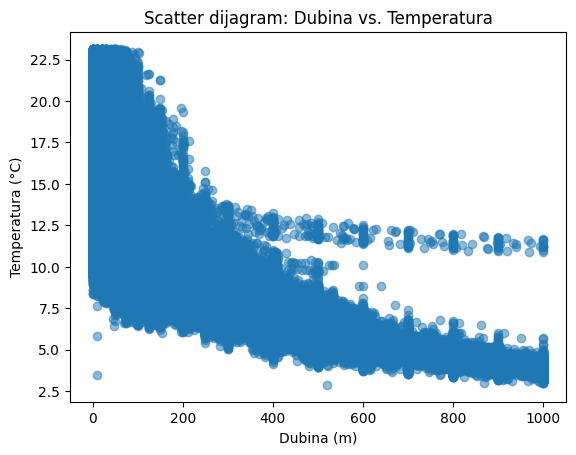

In [ ]:
#2 Vizualizacija: Izrada scatter dijagrama (Depthm – T_degC)
plt.scatter(df_reg["Depthm"], df_reg["T_degC"], alpha=0.5)
plt.xlabel("Dubina (m)")
plt.ylabel("Temperatura (°C)")
plt.title("Scatter dijagram: Dubina vs. Temperatura")
plt.show()

# Interpretacija:
# Očekujemo negativan odnos — temperatura opada s dubinom.

In [ ]:
#3 Procjena modela T_degC = beta_0 + beta_1 x Depthm + epsilon koristeci funkciju linregress()
x = df_reg["Depthm"]
y = df_reg["T_degC"]

slope, intercept, r, p, se = linregress(x, y)

#4 zračun i interpretacija koeficijenata (β_0,β_1), koef korelacije (r) i determinacije (R^2), te p-vrijednosti za nagib
print(f"Jednadžba regresije: y = {intercept:.3f} + {slope:.5f} * x")
print(f"Koeficijent korelacije r = {r:.3f}")
print(f"Koeficijent determinacije R^2 = {r**2:.3f}")
print(f"p-vrijednost za nagib = {p:.5e}")

#𝑇=13.149−0.01208xDepth
#Presjek (13.149) predstavlja procijenjenu temperaturu na površini (dubina = 0 m)
#Nagib (−0.01208) znači da se temperatura smanjuje za oko 0.012 °C po svakom metru dubine

#koef korelacije r=-0.809
#r je negativan i velik po apsolutnoj vrijednosti
#To znači da postoji snažna negativna linearna povezanost između dubine i temperature.
#Kako dubina raste, temperatura se sustavno smanjuje.

#Koeficijent determinacije R² = 0.655
#Model objašnjava 65.5% varijabilnosti temperature.
#To je vrlo solidan rezultat za prirodne oceanske podatke, koji su po prirodi šumoviti.
#Preostalih ~34.5% varijabilnosti dolazi od drugih faktora (lokacija, sezona, struje, salinitet…)

#p‑vrijednost za nagib = 0.00000e+00
#p je ekstremno mala
#To znači da je nagib statistički značajan na bilo kojoj razini značajnosti (α = 0.05, 0.01, 0.001…).
#Dakle, dubina ima statistički značajan utjecaj na temperaturu.

Jednadžba regresije: y = 13.939 + -0.01543 * x
Koeficijent korelacije r = -0.787
Koeficijent determinacije R^2 = 0.620
p-vrijednost za nagib = 0.00000e+00


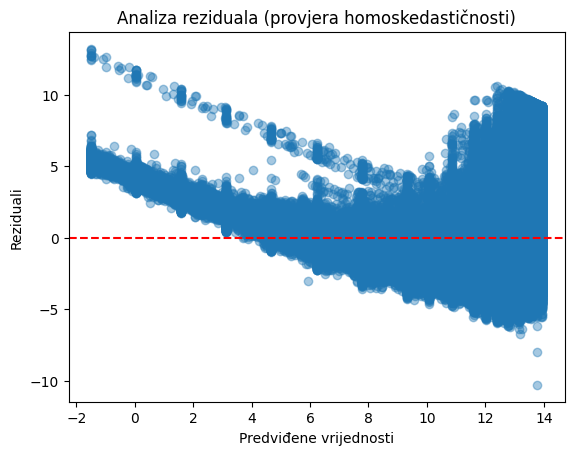

In [ ]:
#4 Analiza reziduala (provjera homoskedastičnosti i adekvatnosti modela)
y_pred = intercept + slope * x
residuals = y - y_pred

plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predviđene vrijednosti")
plt.ylabel("Reziduali")
plt.title("Analiza reziduala (provjera homoskedastičnosti)")
plt.show()

# Interpretacija:
# Ako su reziduali nasumično raspršeni oko nule, bez uzorka,
# pretpostavka homoskedastičnosti je zadovoljena.

#Reziduali nisu ravnomjerno raspršeni oko nule.
#Što su predviđene vrijednosti veće, to je raspon reziduala širi — osobito na desnoj strani grafa.
#To znači da varijanca pogrešaka raste s predviđenom temperaturom.

#PRETPOSTAVKA HOMOSKEDASTIČNOSTI NIJE ZADOVOLJENA

#Analiza reziduala pokazuje da se raspon reziduala povećava s rastom predviđene temperature, što upućuje na heteroskedastičnost.
#Pretpostavka homoskedastičnosti nije zadovoljena, pa se preporučuje oprez pri interpretaciji standardnih pogrešaka i t‑testova.
#Unatoč tome, model pokazuje značajnu negativnu povezanost između dubine i temperature

3. Usporedba rezultata prije i poslije intervencije (Zavisni uzorci)

In [52]:
# učitavanje Excel datoteke
data = pd.read_excel("ispitanici.xlsx")

# provjera strukture
print(data.head())
print(data.info())

        Group  Pre  Post
0  ispitanik1   31    48
1  ispitanik2   39    51
2  ispitanik3   56    67
3  ispitanik4   47    44
4  ispitanik5   29    33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Group   60 non-null     object
 1   Pre     60 non-null     int64 
 2   Post    60 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ KB
None


In [53]:
#1 Deskriptivna statistika rezultata prije i poslije (sredina, medijan, kvartili, standardna devijacija).
pre = data["Pre"]
post = data["Post"]
D = pre - post

print("Srednja razlika (Pre - Post):", D.mean())
print("Standardna devijacija razlika:", D.std())
print("Medijan razlika:", D.median())

mean_pre = np.mean(data['Pre'])
median_pre = np.median(data['Pre'])
first_quartile_pre = np.percentile(data['Pre'], 25)
third_quartile_pre = np.percentile(data['Pre'], 75)
max_pre = np.max(data['Pre'])
min_pre = np.min(data['Pre'])
range_pre = np.max(data['Pre']) - np.min(data['Pre'])

mean_post = np.mean(data['Post'])
median_post = np.median(data['Post'])
first_quartile_post = np.percentile(data['Post'], 25)
third_quartile_post = np.percentile(data['Post'], 75)
max_post = np.max(data['Post'])
min_post = np.min(data['Post'])
range_post = np.max(data['Post']) - np.min(data['Post'])

print("\n")
print("Deskriptivna statistika prije:")
print("\n")
print(f"Prosjek prije: {mean_pre:.2f}")
print(f"Median prije: {median_pre:.2f}")
print(f"Prvi kvartil prije: {first_quartile_pre:.2f}")
print(f"Treci kvartil prije: {third_quartile_pre:.2f}")
print(f"Min prije: {min_pre:.2f}")
print(f"Max prije: {max_pre:.2f}")
print(f"Raspon prije: {range_pre:.2f}")

print("\n")
print("Deskriptivna statistika poslije:")
print("\n")
print(f"Prosjek poslije: {mean_post:.2f}")
print(f"Median poslije: {median_post:.2f}")
print(f"Prvi kvartil poslije: {first_quartile_post:.2f}")
print(f"Treci kvartil poslije: {third_quartile_post:.2f}")
print(f"Min poslije: {min_post:.2f}")
print(f"Max poslije: {max_post:.2f}")
print(f"Raspon poslije: {range_post:.2f}")

Srednja razlika (Pre - Post): -6.45
Standardna devijacija razlika: 7.0456742348570724
Medijan razlika: -8.0


Deskriptivna statistika prije:


Prosjek prije: 37.40
Median prije: 36.00
Prvi kvartil prije: 31.00
Treci kvartil prije: 46.00
Min prije: 11.00
Max prije: 56.00
Raspon prije: 45.00


Deskriptivna statistika poslije:


Prosjek poslije: 43.85
Median poslije: 43.50
Prvi kvartil poslije: 35.75
Treci kvartil poslije: 53.00
Min poslije: 11.00
Max poslije: 67.00
Raspon poslije: 56.00


In [54]:
#2 odabir metode

#provjera normalnosti razlika (Shapiro-Wilk test)
from scipy.stats import shapiro

sh = shapiro(D)
print("Shapiro-Wilk p-vrijednost za razlike:", round(sh.pvalue, 5))
#Ako je p > 0.05 → razlike su normalne → koristi se paired t-test
#Ako je p < 0.05 → razlike nisu normalne → koristi se Wilcoxon signed-rank test
#p=0.05733  => normalne razlike => paired t-test
#Distribucija razlika ne odstupa značajno od normalnosti

Shapiro-Wilk p-vrijednost za razlike: 0.05733


In [55]:
#paired t-test
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(pre, post)
print("Paired t-test p-vrijednost:", round(p_val, 5))
#p=0.0 (premal)

# H0: Nema razlike između rezultata prije i poslije intervencije
# H1: Postoji razlika

# Ako je p < 0.05 → odbacujemo H0 → intervencija ima učinak
# Ako je p > 0.05 → NE odbacujemo H0 → nema dokaza o učinku

#p < 0.05 => Odbacujemo nultu hipotezu H₀
#Postoji statistički značajna razlika između rezultata prije i poslije intervencije
#Intervencija je imala značajan učinak

#Budući da je p‑vrijednost parnog t‑testa ekstremno mala (p < 0.00001),
#odbacujemo nultu hipotezu i zaključujemo da postoji statistički značajna razlika između
#rezultata prije i poslije intervencije.
#Intervencija je imala značajan učinak na poboljšanje rezultata

Paired t-test p-vrijednost: 0.0


In [57]:
if p > 0.05:
  print("Ne postoji znacajna razlika izmedu rezultata ispitanika prije i poslije ")
else:
  print("Postoji znacajna razlika izmedu rezultata ispitanika prije i poslije ")

Postoji znacajna razlika izmedu rezultata ispitanika prije i poslije 


In [56]:
#Wilconxon test - slučaj da nemamo normalnu distribuciju
#from scipy.stats import wilcoxon
#w_stat, p_val = wilcoxon(pre, post)
#print("Wilcoxon test p-vrijednost:", round(p_val, 5))

<Axes: >

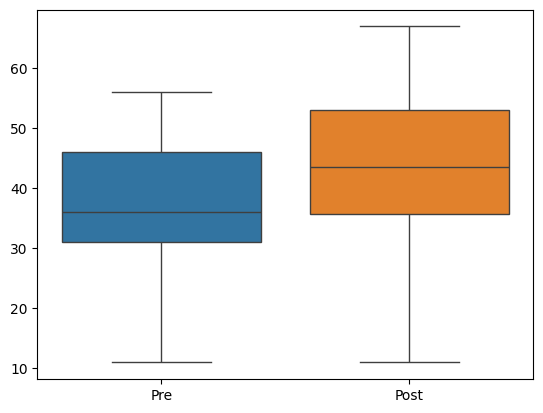

In [58]:
import seaborn as sns
sns.boxplot(data=[data['Pre'], data['Post']])

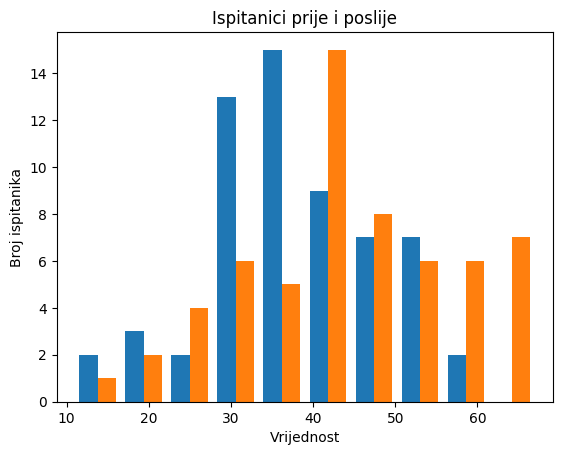

In [59]:
plt.hist([data['Pre'], data['Post']])
plt.title('Ispitanici prije i poslije')
plt.xlabel('Vrijednost')
plt.ylabel('Broj ispitanika')
plt.show()